In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2


In [2]:
from vicon.dereplication.derep import run_vsearch
from vicon.alignment.ref_align import run_viralmsa
from vicon.processing.sample_processing import process_all_samples
from vicon.visualization.plots import plot_non_gap_counts
from vicon.processing.coverage_analysis import abundant_kmers, crop_df, build_coverage_table, top_kmers_df, find_most_frequent_and_calculate_mismatches, get_i_th_kmers, select_best_kmers, count_seq_coverage, find_best_pair_kmer, calculate_kmer_coverage, find_kmer_position
from vicon.io.fasta import read_fasta_to_dataframe
from vicon.processing.sample_processing import pipeline_results_cleaner
from vicon.utils.helpers import count_non_gap_characters_from_dataframe, combine_fasta_files
from vicon.visualization.plots import plot_rel_cons
from vicon.io.fasta import create_folders_and_save_sequences, read_fasta, remove_first_record, read_fasta_to_dataframe
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import shutil

In [3]:

import os

# Get the base path from the environment variable
base_path = os.getenv("PROJECTS_PATH")
base_path = f"{base_path}vicon/"
print(base_path)


/fast/AG_Ohler/ekarimi/projects/vicon/


In [8]:
#!/usr/bin/env python3

from Bio import SeqIO
from collections import defaultdict, Counter
import os
import re
from pathlib import Path

def extract_segment_number(filename):
    """Extract segment number from filename."""
    match = re.search(r'segment\s*(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def get_accession(record):
    """Get accession number without version."""
    if hasattr(record, 'annotations'):
        if 'accessions' in record.annotations and record.annotations['accessions']:
            return record.annotations['accessions'][0]
    return record.id.split('.')[0]

def analyze_segment_distribution(input_dir):
    """Analyze how many accessions have how many segments."""
    # Dictionary to store segments for each accession
    accession_segments = defaultdict(set)
    
    # Process each GenBank file
    for gb_file in sorted(Path(input_dir).glob('*.gb')):
        segment_num = extract_segment_number(gb_file.name)
        if segment_num is None:
            print(f"Warning: Could not extract segment number from {gb_file.name}")
            continue
            
        print(f"Processing segment {segment_num} from {gb_file.name}")
        
        # Parse the GenBank file
        for record in SeqIO.parse(gb_file, "genbank"):
            accession = get_accession(record)
            accession_segments[accession].add(segment_num)
    
    # Count how many accessions have each number of segments
    segment_counts = Counter(len(segments) for segments in accession_segments.values())
    
    # Print results
    print("\nSegment distribution:")
    print("Number of segments | Number of accessions")
    print("-" * 40)
    for num_segments in sorted(segment_counts.keys()):
        print(f"{num_segments:^16} | {segment_counts[num_segments]:^19}")
    
    # Print accessions with all 11 segments
    complete_accessions = [acc for acc, segments in accession_segments.items() 
                         if len(segments) == 11]
    
    print(f"\nFound {len(complete_accessions)} accessions with all 11 segments")
    
    # Print accessions with only one segment
    single_segment_accessions = [acc for acc, segments in accession_segments.items() 
                               if len(segments) == 1]
    
    print(f"Found {len(single_segment_accessions)} accessions with only 1 segment")
    
    # Save detailed results to a file
    output_dir = os.path.join(os.path.dirname(input_dir), "analysis")
    os.makedirs(output_dir, exist_ok=True)
    
    with open(os.path.join(output_dir, "segment_distribution.txt"), 'w') as f:
        f.write("Accession\tNumber of segments\tSegment numbers\n")
        for accession, segments in sorted(accession_segments.items()):
            segments_str = ','.join(str(s) for s in sorted(segments))
            f.write(f"{accession}\t{len(segments)}\t{segments_str}\n")
    
    return accession_segments, segment_counts

def main():
    # Set input path
    input_dir = "/fast/AG_Ohler/ekarimi/projects/vicon/data/rotav/Human_Rotavirus_A_1"
    
    print("Analyzing segment distribution...")
    accession_segments, segment_counts = analyze_segment_distribution(input_dir)
    
    print("\nDetailed results have been saved to 'segment_distribution.txt'")

if __name__ == "__main__":
    main() 

Analyzing segment distribution...
Processing segment 1 from Rotavirus A segment 1.gb
Processing segment 10 from Rotavirus A segment 10.gb
Processing segment 11 from Rotavirus A segment 11.gb
Processing segment 2 from Rotavirus A segment 2.gb
Processing segment 3 from Rotavirus A segment 3.gb
Processing segment 4 from Rotavirus A segment 4.gb
Processing segment 5 from Rotavirus A segment 5.gb
Processing segment 6 from Rotavirus A segment 6.gb
Processing segment 7 from Rotavirus A segment 7.gb
Processing segment 8 from Rotavirus A segment 8.gb
Processing segment 9 from Rotavirus A segment 9.gb

Segment distribution:
Number of segments | Number of accessions
----------------------------------------
       1         |        35846       

Found 0 accessions with all 11 segments
Found 35846 accessions with only 1 segment

Detailed results have been saved to 'segment_distribution.txt'


In [6]:
#!/usr/bin/env python3

from Bio import SeqIO
from Bio.Seq import Seq
from collections import defaultdict
import os
import re
from pathlib import Path

def extract_segment_number(filename):
    """Extract segment number from filename."""
    match = re.search(r'segment\s*(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def parse_collection_date(date_str):
    """Parse and standardize collection date."""
    if not date_str:
        return "NA"
    # Remove any text in parentheses
    date_str = re.sub(r'\([^)]*\)', '', date_str).strip()
    return date_str

def extract_sequence_from_origin(record):
    """Extract sequence from ORIGIN section of GenBank record."""
    if not hasattr(record, '_raw') or not record._raw:
        return None
    
    # Find ORIGIN section
    origin_match = re.search(r'ORIGIN\s*(.*?)\/\/', record._raw, re.DOTALL)
    if not origin_match:
        return None
    
    # Extract sequence
    origin_text = origin_match.group(1)
    # Remove numbers and whitespace, join all lines
    sequence = ''.join(re.sub(r'[\d\s]', '', line) for line in origin_text.split('\n'))
    return sequence.upper()

def extract_record_info(record):
    """Extract required information from a GenBank record."""
    # Initialize default values
    info = {
        'accession': record.id,
        'organism': 'NA',
        'geo_loc_name': 'NA',
        'collection_date': 'NA'
    }
    
    # Get organism
    if hasattr(record, 'annotations') and 'organism' in record.annotations:
        info['organism'] = record.annotations['organism']
    
    # Extract features from source
    for feature in record.features:
        if feature.type == 'source':
            qualifiers = feature.qualifiers
            if 'country' in qualifiers:
                info['geo_loc_name'] = qualifiers['country'][0]
            if 'collection_date' in qualifiers:
                info['collection_date'] = parse_collection_date(qualifiers['collection_date'][0])
    
    return info

def process_genbank_files(input_dir):
    """Process all GenBank files and organize sequences by strain."""
    # Dictionary to store sequences by accession
    sequences_by_strain = defaultdict(dict)
    
    # Process each GenBank file
    for gb_file in sorted(Path(input_dir).glob('*.gb')):
        segment_num = extract_segment_number(gb_file.name)
        if segment_num is None:
            print(f"Warning: Could not extract segment number from {gb_file.name}")
            continue
            
        print(f"Processing segment {segment_num} from {gb_file.name}")
        
        # Parse the GenBank file
        for record in SeqIO.parse(gb_file, "genbank"):
            info = extract_record_info(record)
            
            # Try to get sequence from record.seq first
            try:
                sequence = str(record.seq).upper()
            except:
                # If that fails, try to extract from ORIGIN section
                sequence = extract_sequence_from_origin(record)
                if not sequence:
                    print(f"Warning: Could not extract sequence for {record.id} in segment {segment_num}")
                    continue
            
            # Create a unique identifier for this strain
            strain_key = f"{info['accession']}"
            
            # Store the sequence and information
            sequences_by_strain[strain_key][segment_num] = {
                'sequence': sequence,
                'info': info
            }
    
    return sequences_by_strain

def write_concatenated_sequences(sequences_by_strain, output_file):
    """Write concatenated sequences to a FASTA file."""
    with open(output_file, 'w') as f:
        for strain_key, segments in sequences_by_strain.items():
            # Only process strains that have all segments
            if len(segments) != 11:  # Rotavirus A has 11 segments
                print(f"Warning: Strain {strain_key} has only {len(segments)} segments, skipping")
                continue
            
            # Get info from any segment (they should all be the same)
            info = next(iter(segments.values()))['info']
            
            # Create header
            header = f">{info['accession']}|{','.join(str(i) for i in range(1,12))}|{info['organism']}|{info['geo_loc_name']}|{info['collection_date']}"
            
            # Concatenate sequences in order of segments
            concatenated_seq = ''.join(segments[i]['sequence'] for i in range(1, 12))
            
            # Write to file
            f.write(f"{header}\n")
            
            # Write sequence in lines of 80 characters
            for i in range(0, len(concatenated_seq), 80):
                f.write(concatenated_seq[i:i+80] + '\n')



In [7]:
def main():
    # Set input and output paths
    input_dir = "/fast/AG_Ohler/ekarimi/projects/vicon/data/rotav/Human_Rotavirus_A_1"
    output_dir = os.path.join(os.path.dirname(input_dir), "concatenated")
    os.makedirs(output_dir, exist_ok=True)
    
    output_file = os.path.join(output_dir, "concatenated_sequences.fasta")
    
    print("Processing GenBank files...")
    sequences_by_strain = process_genbank_files(input_dir)
    
    print("Writing concatenated sequences...")
    write_concatenated_sequences(sequences_by_strain, output_file)
    
    print(f"Done! Output written to {output_file}")

if __name__ == "__main__":
    main()

Processing GenBank files...
Processing segment 1 from Rotavirus A segment 1.gb
Processing segment 10 from Rotavirus A segment 10.gb
Processing segment 11 from Rotavirus A segment 11.gb
Processing segment 2 from Rotavirus A segment 2.gb
Processing segment 3 from Rotavirus A segment 3.gb
Processing segment 4 from Rotavirus A segment 4.gb


/fast/AG_Ohler/ekarimi/miniforge/envs/vicon/lib/python3.11/site-packages/Bio/GenBank/__init__.py:645: BiopythonParserWarning: GenBank TITLE line without REFERENCE line.
  warnings.warn(
/fast/AG_Ohler/ekarimi/miniforge/envs/vicon/lib/python3.11/site-packages/Bio/GenBank/Scanner.py:1221: BiopythonParserWarning: Blank line in sequence data
  warnings.warn("Blank line in sequence data", BiopythonParserWarning)
/fast/AG_Ohler/ekarimi/miniforge/envs/vicon/lib/python3.11/site-packages/Bio/GenBank/__init__.py:752: BiopythonParserWarning: The NCBI states double-quote characters like " should be escaped as "" (two double - quotes), but here it was not: '"YRQLLTNSYSVDLHEEIEQIGSEKTQNVTVNPGPFAQTRYAPVN WGHGEINDSTTVEPVLDGPYQPTTFKPPNDYWLLISSNTDGVVYESTNNSDFWTAVIA VEPHVSQTNRQYVLFGENKQFNIENSSDKWKFFEMFKGSSQSDFSNRRTLTSNNRLVG MLKYGGRVWTFHGETPRATTDSSNTADLNNISIIIHSEFYIIPRSQESKCNEYINNGL PPIQNTRNVVPLSLSSRSIQYRRAQVNEDITISKTSLWKEMQYNRDIVIXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXX

Processing segment 5 from Rotavirus A segment 5.gb
Processing segment 6 from Rotavirus A segment 6.gb
Processing segment 7 from Rotavirus A segment 7.gb
Processing segment 8 from Rotavirus A segment 8.gb
Processing segment 9 from Rotavirus A segment 9.gb
Writing concatenated sequences...
Done! Output written to /fast/AG_Ohler/ekarimi/projects/vicon/data/rotav/concatenated/concatenated_sequences.fasta


In [4]:


VIRUS = "rsvb"
INPUT_SAMPLE = f"{base_path}data/rsvb/samples/RSVB_1973-2023-10.fasta"
INPUT_REFERENCE = f"{base_path}data/rsvb/reference/EPI_ISL_1653999-RSVB-Ref.fasta"

VIRALMSA_PATH = os.path.join(f"{base_path}scripts/ViralMSA.py")
OUTPUT_DIR = os.path.join(f"{base_path}results", VIRUS)

# Parameters for Tools
EMAIL = "email@address.com"
KMER_SIZE = 150
THRESHOLD = 147
L_GENE_START = 8000
L_GENE_END = 16000

SAMPLE_DIR = os.path.dirname(INPUT_SAMPLE)
REFERENCE_DIR = os.path.dirname(INPUT_REFERENCE)

LOG_DIR = os.path.join(OUTPUT_DIR, "logs")
MAIN_DF_PATH = os.path.join(OUTPUT_DIR, "aggregated_results.csv")
KMER1_PATH = os.path.join(OUTPUT_DIR, "kmer1.csv")
KMER2_PATH = os.path.join(OUTPUT_DIR, "kmer2.csv")

# File Names
SAMPLE_NAME = os.path.basename(INPUT_SAMPLE)
REFERENCE_NAME = os.path.basename(INPUT_REFERENCE)

# Paths
DEREP_FASTA = os.path.join(SAMPLE_DIR, "derep.fasta")
CLUSTERS_UC = os.path.join(SAMPLE_DIR, "clusters.uc")
ALIGNED_DIR = os.path.join(SAMPLE_DIR, "aligned")
if os.path.exists(ALIGNED_DIR):
    shutil.rmtree(ALIGNED_DIR)
DEREP_FASTA_ALN = os.path.join(ALIGNED_DIR, "derep.fasta.aln")



# Example Usage of Paths and Functions
run_vsearch(INPUT_SAMPLE, DEREP_FASTA, CLUSTERS_UC)
run_viralmsa(
    email=EMAIL, 
    sample_fasta=DEREP_FASTA, 
    output_dir=ALIGNED_DIR, 
    reference_fasta=INPUT_REFERENCE, 
    script_path=VIRALMSA_PATH
)

remove_first_record(DEREP_FASTA_ALN, DEREP_FASTA_ALN)

# Process all samples and aggregate results
df, mask = process_all_samples(INPUT_REFERENCE, DEREP_FASTA_ALN, LOG_DIR, window_size=KMER_SIZE, threshold=THRESHOLD, only_valid_kmers=True)
df3, mask3 = process_all_samples(INPUT_REFERENCE, DEREP_FASTA_ALN, LOG_DIR, window_size=KMER_SIZE, threshold=KMER_SIZE-3, only_valid_kmers=True)

# Save aggregated results
# df.to_csv(MAIN_DF_PATH)
# print("Aggregated results saved.")

# df = pd.read_csv(MAIN_DF_PATH, index_col="SampleID")
df


vsearch v2.29.1_linux_x86_64, 1509.9GB RAM, 80 cores
https://github.com/torognes/vsearch

Dereplicating file /fast/AG_Ohler/ekarimi/projects/vicon/data/rsvb/samples/RSVB_1973-2023-10.fasta 100%
69739256 nt in 4591 seqs, min 14901, max 15885, avg 15190
Sorting 100%
4305 unique sequences, avg cluster 1.1, median 1, max 12
Writing FASTA output file 100%
Writing uc file, first part 100%
Writing uc file, second part 100%
The first record has been removed. Updated FASTA saved to: /fast/AG_Ohler/ekarimi/projects/vicon/data/rsvb/samples/aligned/derep.fasta.aln


,0,1,2,3,4,5,6,7,8,9,...,15063,15064,15065,15066,15067,15068,15069,15070,15071,15072
SampleID,,,,,,,,,,,,,,,,,,,,,
hRSV/B/New_Zealand/IESR-VR0966/2021|EPI_ISL_16959868|2021-07-02;size=12,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
hRSV/B/Australia/VIC-MMC001/2020|EPI_ISL_11817110|2020-12-10;size=10,0,0,0,1,1,1,1,1,1,1,...,1,1,1,0,0,0,0,0,0,0
hRSV/B/Australia/NT-RDH0261/2022|EPI_ISL_15896280|2022-08-24;size=8,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
hRSV/B/Kenya/Kilifi-HH-1902-28-Feb/2010|EPI_ISL_2575482|2010-02-28;size=5,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
hRSV/B/Netherlands/un-DP-UU02-0028-D03/2018|EPI_ISL_15753162|2018-01-02;size=5,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hRSV/b/Slovakia/2716/2023|EPI_ISL_17481657|2023-03-01;size=1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hRSV/b/Slovakia/2936/2023|EPI_ISL_17481659|2023-03-09;size=1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hRSV/b/Slovakia/2942/2023|EPI_ISL_17481660|2023-03-07;size=1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


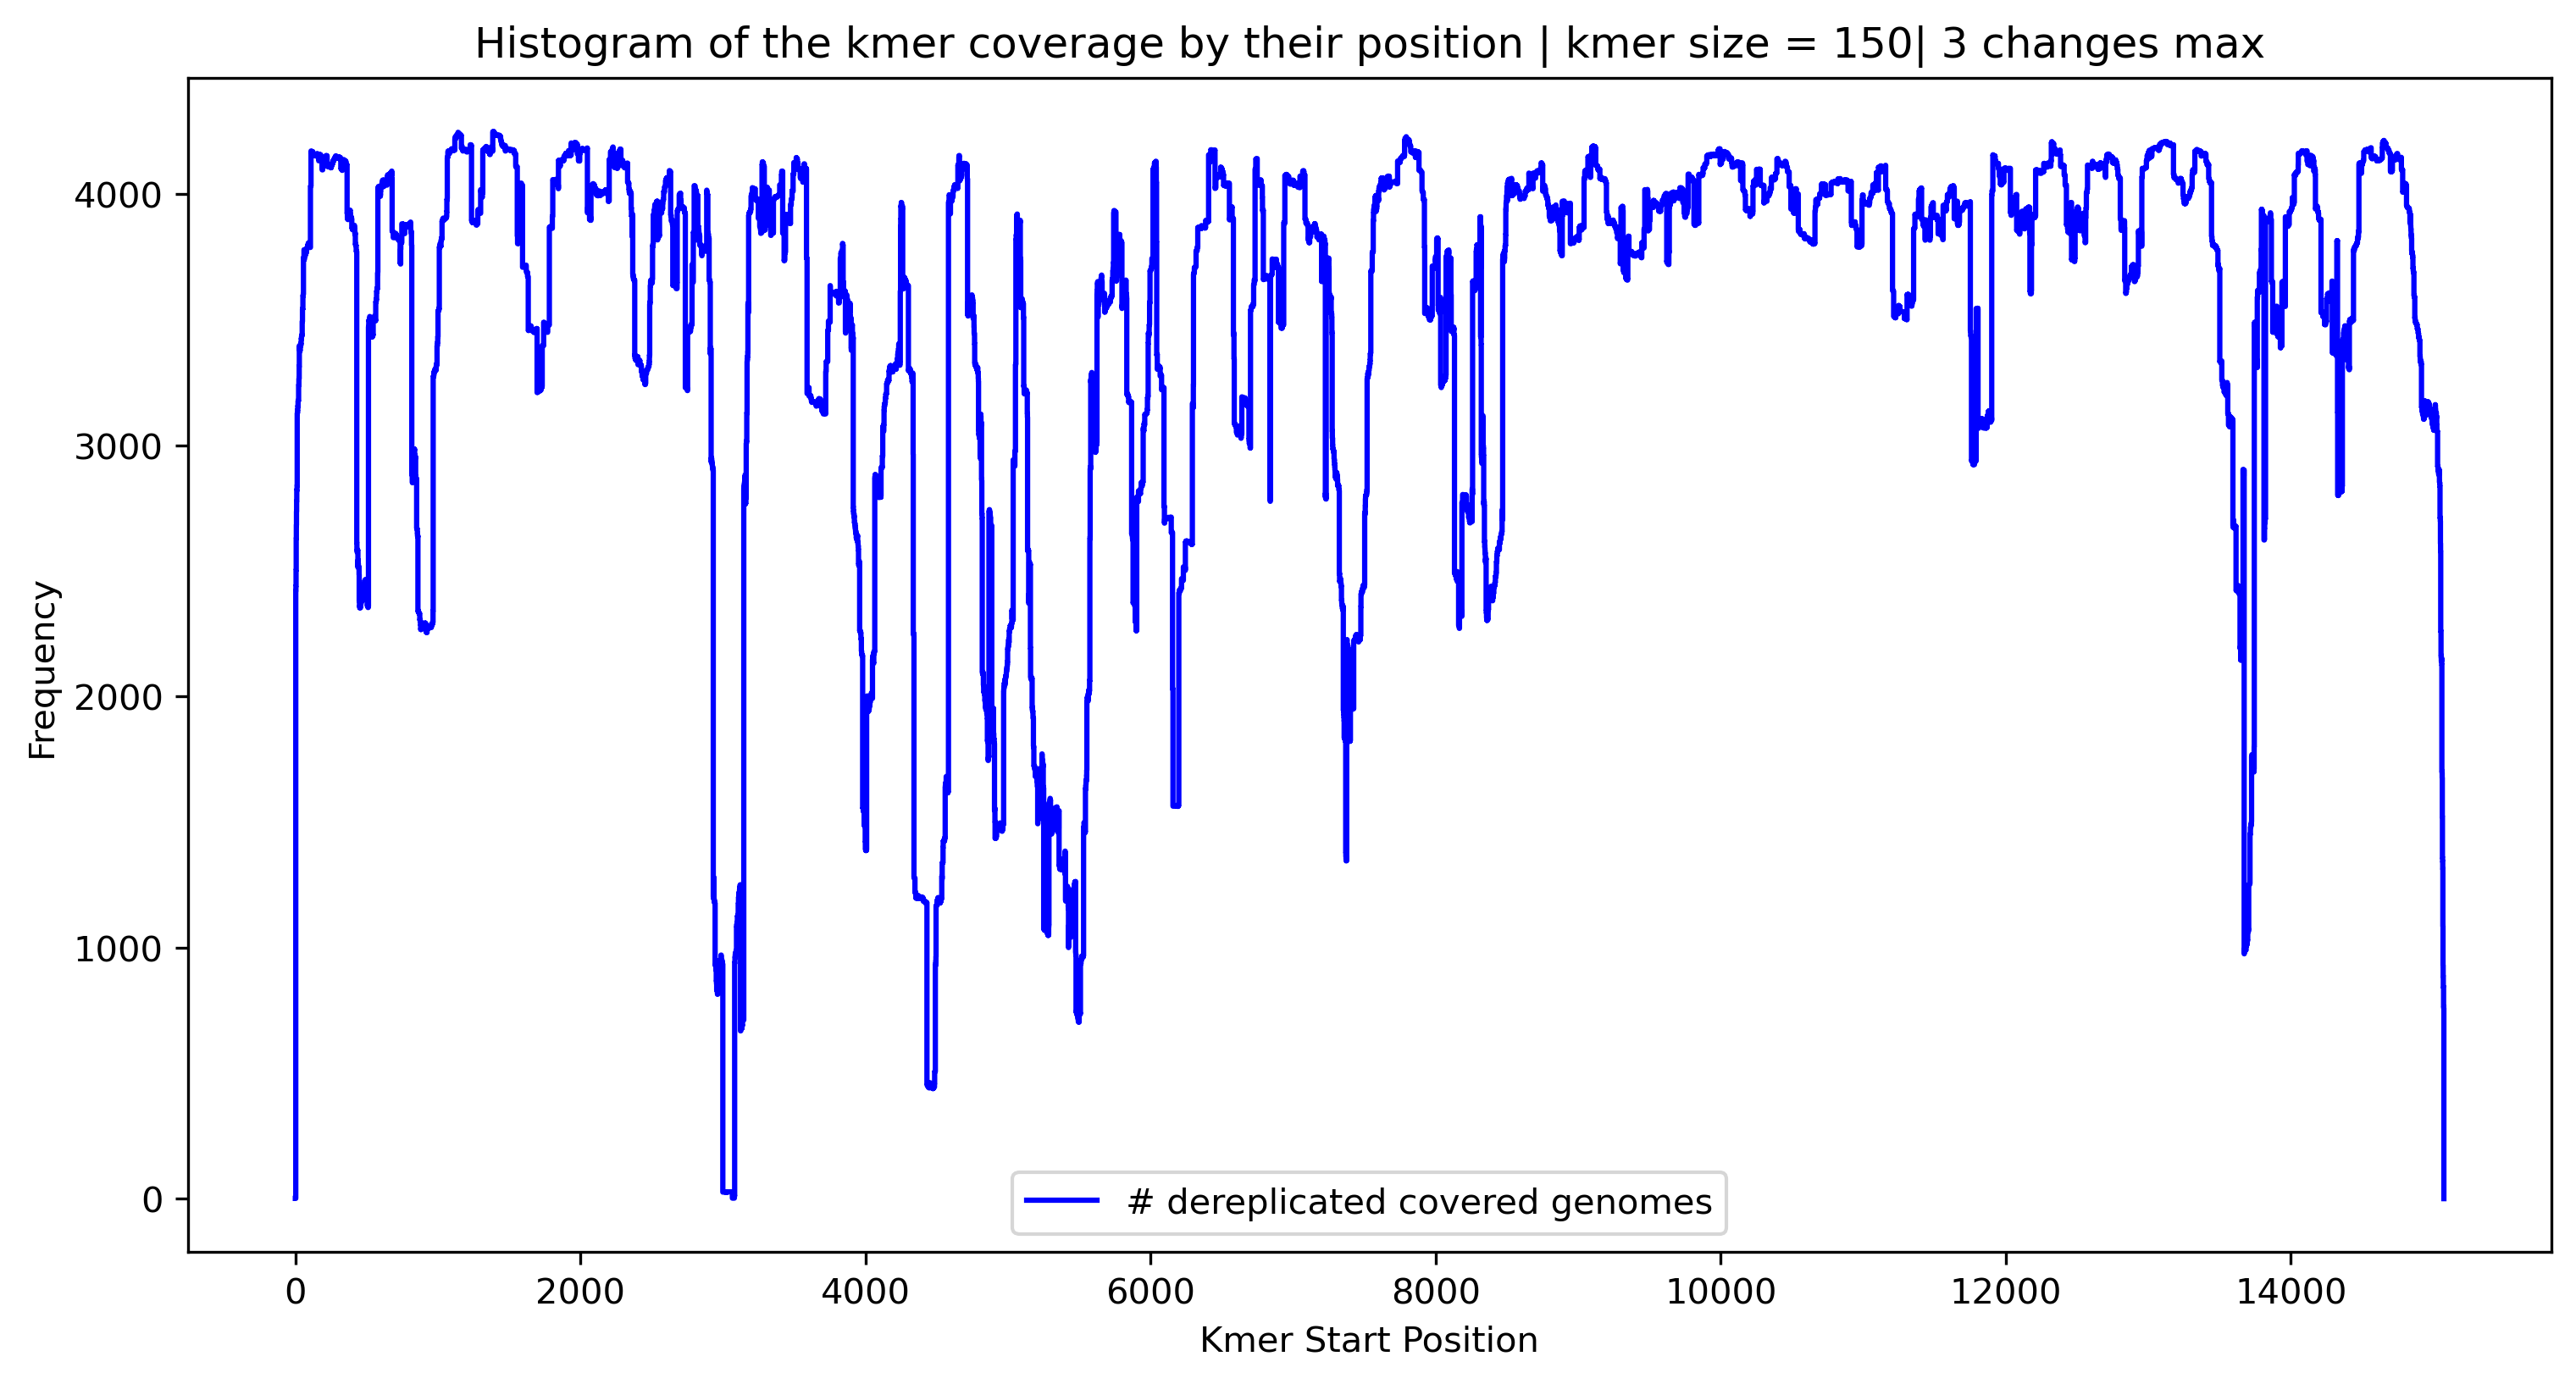

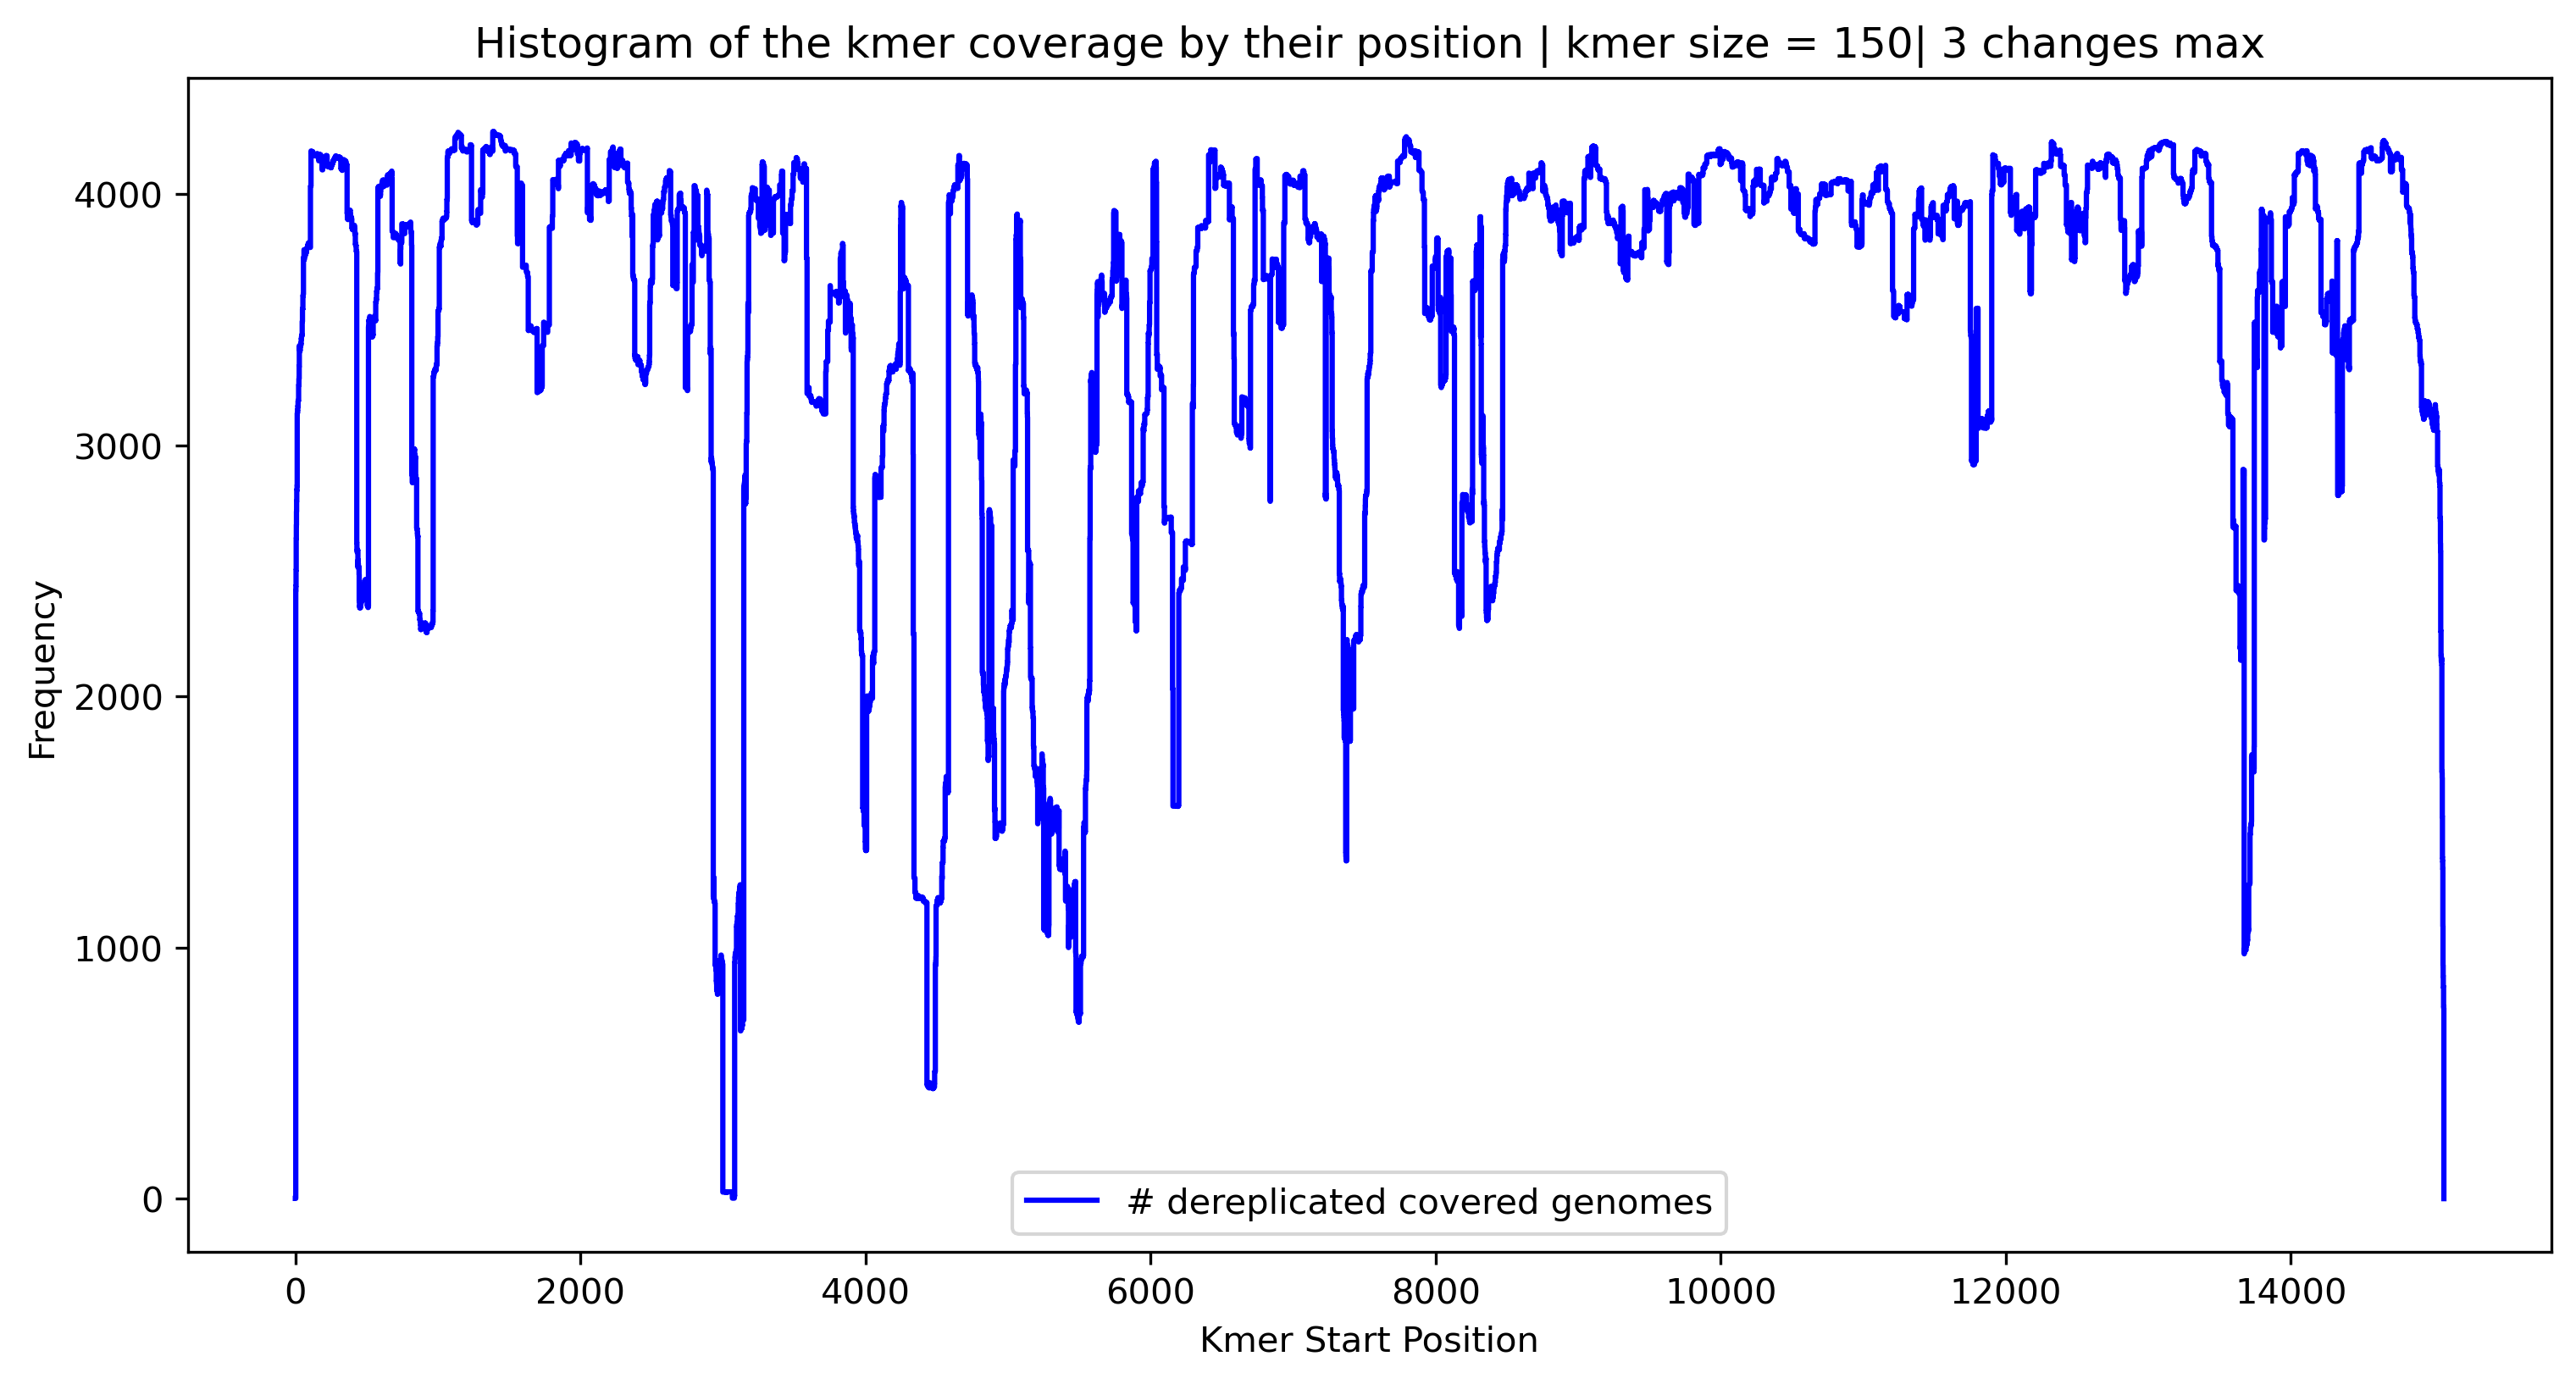

In [5]:
df.columns = df.columns.astype(int)
plot_rel_cons(df,kmer_size=KMER_SIZE, threshold=KMER_SIZE-THRESHOLD)
plot_rel_cons(df3, kmer_size=KMER_SIZE, threshold=3)


In [ ]:
# This should be defined based on the plots you get
COVERAGE_RATIO = 0.5 # 3500/ df3.shape[0]

# Crop DataFrame to L gene region and apply coverage threshold
# ldf = crop_df(df, L_GENE_START, L_GENE_END, coverage_ratio=COVERAGE_RATIO)
# kmer1, kmer2 = find_best_pair_kmer(ldf, DEREP_FASTA_ALN, mask, window_size=150)
ldf = crop_df(df3, L_GENE_START, L_GENE_END, coverage_ratio=COVERAGE_RATIO)
kmer1, kmer2 = find_best_pair_kmer(ldf, DEREP_FASTA_ALN, mask3, window_size=KMER_SIZE)

Limiting DataFrame to gene region from position 8000 to 16000
Minimum coverage threshold set to 2152 based on coverage ratio 0.5
DataFrame cropped to 6980 columns with coverage above threshold.


In [ ]:
df_ref = read_fasta_to_dataframe(INPUT_REFERENCE)
ref_seq = df_ref['Sequence'].values[0]

# Extract kmer sequences
kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]

print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")




df_kmers1, df_kmers2 = pipeline_results_cleaner(sample_address=DEREP_FASTA_ALN,
                                                kmer1=kmer1,
                                                kmer2=kmer2,
                                                drop_old_samples=False,
                                                kmer_size= 150,
                                                min_year=2020,
                                                threshold_ratio=0.01,
                                                drop_mischar_samples=True
                                                # drop_mutants=False
                                               )


df_kmers1.to_csv(KMER1_PATH)
df_kmers2.to_csv(KMER2_PATH)


df_counts = count_non_gap_characters_from_dataframe(df_kmers1, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VIRUS}**kmers1 -- Non-Gap Character Counts at Each Position',
                    save = os.path.join(OUTPUT_DIR, "kmers1_mutations.png"))

df_counts = count_non_gap_characters_from_dataframe(df_kmers2, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VIRUS}**kmers2 -- Non-Gap Character Counts at Each Position',
                    save = os.path.join(OUTPUT_DIR, "kmers2_mutations.png"))

In [20]:
kk1 = 'AATGATAGCCGAAAATATTTTACAATTCTTCCCTGAGAGTTTGACAAGATATGGTGATCTAGAGCTTCAAAAGATATTAGAATTAAAAGCAGGAATAAGCAACAAGTCAAATCGTTATAATGATAACTACAACAATTATATCAGTAAATG'
kk2 = 'TGTTTTCTTTAATGCTTATAAGACTTATTTGCTATGTTTTCATAGAGGTTATGGTAAAGCAAAATTAGAATGTGATATGAACACTTCAGATCTTCTTTGTGTTTTGGAGTTAATAGACAGTAGCTACTGGAAATCTATGTCTAAAGTTTT'


In [21]:
k1_pos = find_kmer_position(df_ref, kk1, window_size=150)

In [22]:
k2_pos = find_kmer_position(df_ref, kk2, window_size=150)

In [23]:
calculate_kmer_coverage(ldf, DEREP_FASTA_ALN, mask3, k1_pos, k2_pos, window_size=150)/ldf.shape[0]

0.9902439024390244